In [48]:
import pandas as pd
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('country_vaccinations.csv')
data.isna().any().sum()
# checking for null values

9

In [49]:
country_wise = data.groupby("country")

In [50]:
data["country"].nunique()

223

In [51]:
data['date'] = pd.to_datetime(data['date'])

In [52]:
# finding countries with maximum and minimum vaccinated percentages
data.dropna(subset = 'people_fully_vaccinated_per_hundred',inplace = True)
fully_vaxxed = data[['country','date','people_fully_vaccinated_per_hundred']]
indices = fully_vaxxed.groupby('country')['people_fully_vaccinated_per_hundred'].idxmax()
new_indices_max = fully_vaxxed.loc[indices]
max_idx = new_indices_max['people_fully_vaccinated_per_hundred'].idxmax()
max_country = new_indices_max.loc[max_idx]
print(max_country)
new_indices_min = fully_vaxxed.loc[indices]
min_idx = new_indices_min['people_fully_vaccinated_per_hundred'].idxmin()
min_country = new_indices_min.loc[min_idx]
print(min_country)

country                                          Gibraltar
date                                   2022-03-24 00:00:00
people_fully_vaccinated_per_hundred                 122.37
Name: 30235, dtype: object
country                                            Burundi
date                                   2022-03-12 00:00:00
people_fully_vaccinated_per_hundred                   0.08
Name: 12638, dtype: object


In [53]:
# getting top 10% and bottom 10% countries
new_indices = pd.DataFrame(new_indices_max)
sorted = new_indices.sort_values(by='people_fully_vaccinated_per_hundred', ascending = False).head(23)
print(sorted)
print(sorted['country'])

                    country       date  people_fully_vaccinated_per_hundred
30235             Gibraltar 2022-03-24                               122.37
62293              Pitcairn 2021-09-07                               100.00
81914  United Arab Emirates 2022-03-27                                96.12
63189              Portugal 2022-03-10                                92.60
11745                Brunei 2022-03-18                                91.71
70228             Singapore 2022-03-28                                91.04
49111                 Malta 2022-03-28                                90.35
15755                 Chile 2022-03-22                                90.29
63647                 Qatar 2022-03-24                                88.50
14701        Cayman Islands 2022-03-25                                87.80
57358                  Niue 2022-03-13                                87.79
19243                  Cuba 2022-03-27                                87.57
72972       

In [54]:
print((new_indices).head())

          country       date  people_fully_vaccinated_per_hundred
393   Afghanistan 2022-03-22                                11.10
832       Albania 2022-03-24                                42.30
1237      Algeria 2022-03-09                                13.70
1650      Andorra 2022-03-13                                68.99
2040       Angola 2022-03-25                                17.66


In [55]:
# imtegrating continent data
def get_cont(country_name):
    try:
        country_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (LookupError, KeyError):
        return None

In [56]:
# adding continent list as a column
cont_list = []
for country in new_indices['country']:
    continent = get_cont(country)
    cont_list.append(continent)


In [57]:
new_indices['continent'] = cont_list
print(new_indices.head())

          country       date  people_fully_vaccinated_per_hundred continent
393   Afghanistan 2022-03-22                                11.10      Asia
832       Albania 2022-03-24                                42.30    Europe
1237      Algeria 2022-03-09                                13.70    Africa
1650      Andorra 2022-03-13                                68.99    Europe
2040       Angola 2022-03-25                                17.66    Africa


In [58]:
# getting mean vaccination rates for all continents
cont_vacc =new_indices.groupby('continent')['people_fully_vaccinated_per_hundred'].mean().reset_index()
print(cont_vacc)

       continent  people_fully_vaccinated_per_hundred
0         Africa                            21.062400
1           Asia                            58.768261
2         Europe                            66.505652
3  North America                            54.918710
4        Oceania                            58.877647
5  South America                            64.871667


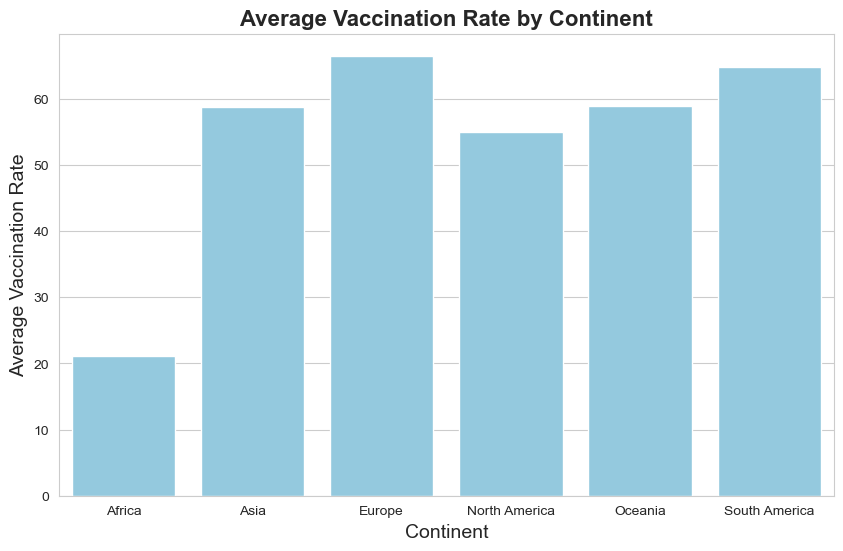

In [61]:
# graph creation
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=cont_vacc,x='continent',y='people_fully_vaccinated_per_hundred',color = 'skyblue')
plt.title('Average Vaccination Rate by Continent', fontsize = 16, fontweight = 'bold')
plt.xlabel('Continent', fontsize = 14)
plt.ylabel('Average Vaccination Rate', fontsize = 14)
plt.show()